In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Be sure you use GPU mode, otherwise it will take forever to train CNN
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda GeForce GTX 1660 SUPER


In [3]:
#Load ImageNet pre-trained VGG19
model = torchvision.models.vgg19(pretrained=True)

c:\Users\ADMIN\SLenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\SLenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### How to fix the parameters of a NN?
1. model.features.eval() <br>
2. for param in model.features.parameters(): <br>
    param.requires_grad = False<br>
3. with torch.no_grad(): <br>


In [4]:
# fix the weight of convolution layers
model.features.eval()

# modify classifier
model.classifier = torch.nn.Sequential(
  nn.Linear(25088, 4096),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(4096, 4096),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.5, inplace=False),
  torch.nn.Linear(4096, 2))

In [5]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Load training images

In [7]:
transformer = transforms.Compose([
     transforms.Resize((224, 224)),       
     transforms.ToTensor(),                     
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] )])

If you connect to Google drive from Colob, run following two cells

In [ ]:
#from google.colab import drive
#drive.mount("/content/gdrive", force_remount=True)

In [ ]:
#train_dataset = datasets.ImageFolder(root = "/content/gdrive/MyDrive/新增資料夾/train" , transform = transformer)

If you run on your PC or you upload image files to Colob, run following cell <br>

In [8]:
train_dataset = datasets.ImageFolder(root = "./train" , transform = transformer) 

In [9]:
classes = train_dataset.classes
classes_index = train_dataset.class_to_idx
print(classes)
print(classes_index)

['angry', 'happy']
{'angry': 0, 'happy': 1}


In [10]:
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # Remaining 20% for validation

In [11]:
# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [12]:
# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

### Step by step practice to send a batch of training images to NN

In [13]:
for batchX, batchY_hat in train_loader:
  break
print(batchX.shape, batchY_hat.shape, batchY_hat)

torch.Size([1, 3, 224, 224]) torch.Size([1]) tensor([1])


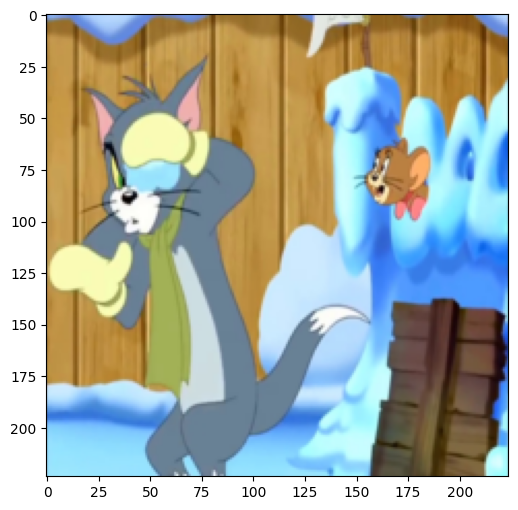

['happy']


In [14]:
imgTensor = torchvision.utils.make_grid(batchX)
imgArray = imgTensor.numpy() 
imgArray1 = np.zeros((imgArray.shape[1], imgArray.shape[2], 3))
imgArray1[:,:,0] = imgArray[0, :, :]  
imgArray1[:,:,1] = imgArray[1, :, :]
imgArray1[:,:,2] = imgArray[2, :, :]
imgArray1 = imgArray1*0.5+0.5
plt.figure(figsize=(12, 6))
plt.imshow(imgArray1)
plt.show()
print([classes[i] for i in batchY_hat])

In [15]:
tensorY=model(batchX.to(device))
print(tensorY.shape,"\n", tensorY)

torch.Size([1, 2]) 
 tensor([[-0.1399,  0.1272]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [16]:
loss = loss_func(tensorY, batchY_hat.to(device))
print(tensorY.shape, batchY_hat.shape, loss)

torch.Size([1, 2]) torch.Size([1]) tensor(0.5685, device='cuda:0', grad_fn=<NllLossBackward0>)


# Training loop

In [17]:
# train NN 
train_lossLst = []
validation_lossLst = []
for epoch in range(1, 5):
  if(epoch%100 == 0):
    print(epoch, end=",")
  epoch_lossLst=[]
  for (batchX, batchY) in train_loader:
    batchY_hat = model(batchX.to(device))
    loss = loss_func(batchY_hat, batchY.to(device))
    epoch_lossLst.append(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg = sum(epoch_lossLst) / len(epoch_lossLst)
  train_lossLst.append(avg) 

  with torch.no_grad():
      epoch_lossLst=[]
      for (batchX, batchY) in val_loader:
          batchY_hat = model(batchX.to(device))
          loss = loss_func(batchY_hat, batchY.to(device))
          epoch_lossLst.append(float(loss))
      avg = sum(epoch_lossLst) / len(epoch_lossLst)
      validation_lossLst.append(avg)

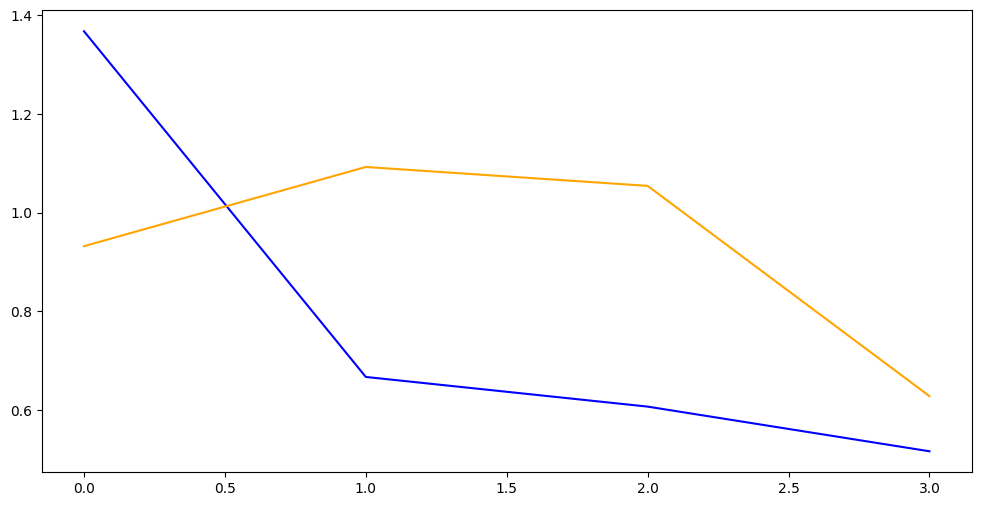

In [18]:
fig=plt.figure(figsize=(12, 6))
plt.plot(train_lossLst, color='blue')
plt.plot(validation_lossLst, color='orange')
plt.show()

# Test

In [19]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [26]:
test_dataset = datasets.ImageFolder(root = "./test" , transform = transformer) 
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [27]:
with torch.no_grad():
      epoch_lossLst=[]
      for (batchX, batchY) in test_loader:
          batchY_hat = model(batchX.to(device))
          batchY_hat = torch.softmax(batchY_hat, 1)
          print(batchY, batchY_hat)

tensor([0]) tensor([[0.5286, 0.4714]], device='cuda:0')
tensor([0]) tensor([[0.5411, 0.4589]], device='cuda:0')
tensor([0]) tensor([[0.5973, 0.4027]], device='cuda:0')
tensor([1]) tensor([[0.5924, 0.4076]], device='cuda:0')
tensor([1]) tensor([[0.5660, 0.4340]], device='cuda:0')
tensor([1]) tensor([[0.5565, 0.4435]], device='cuda:0')


### Build a customized data loader so we can load file name information

In [24]:
class ImageFolderWithPaths(datasets.ImageFolder):
  """Custom dataset that includes image file names. Extends
  torchvision.datasets.ImageFolder
  """
  # override the __getitem__ method. this is the method that dataloader calls
  def __getitem__(self, index):
    # this is what ImageFolder normally returns 
    original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
    # the image file path
    path = self.imgs[index][0]
    # make a new tuple that includes original and the path
    tuple_with_path = (original_tuple + (path,))
    return tuple_with_path

In [28]:
test_dataset1 = ImageFolderWithPaths(root = "./test", transform = transformer) # our custom dataset
test_loader1 = DataLoader(test_dataset1, batch_size=1, shuffle=False)

In [31]:
with torch.no_grad():
      epoch_lossLst=[]
      for batchX, batchY, paths in test_loader1:
          batchY_hat = model(batchX.to(device))
          batchY_hat = torch.softmax(batchY_hat, 1)
          print(paths, batchY, batchY_hat)

('./test\\angry\\frame27.jpg',) tensor([0]) tensor([[0.5286, 0.4714]], device='cuda:0')
('./test\\angry\\frame29.jpg',) tensor([0]) tensor([[0.5411, 0.4589]], device='cuda:0')
('./test\\angry\\frame46.jpg',) tensor([0]) tensor([[0.5973, 0.4027]], device='cuda:0')
('./test\\happy\\frame41.jpg',) tensor([1]) tensor([[0.5924, 0.4076]], device='cuda:0')
('./test\\happy\\frame42.jpg',) tensor([1]) tensor([[0.5660, 0.4340]], device='cuda:0')
('./test\\happy\\frame52.jpg',) tensor([1]) tensor([[0.5565, 0.4435]], device='cuda:0')
